In [1]:
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, utils, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Ссылка на датасет - https://www.kaggle.com/alxmamaev/flowers-recognition

**Содержимое датасета**:  
  Картины разделены на пять классов: ромашка, тюльпан, роза, подсолнух, одуванчик.
  На каждый класс приходится около 800 фотографий. Разрешение фотографий около 320х240 пикселей.

**Задача**:  
  обучить нейросеть, которая будет определять: какой тип цветов изображён на картинке.

In [2]:
RANDOM_STATE = 17
torch.manual_seed(RANDOM_STATE)
random.seed = RANDOM_STATE

In [74]:
BATCH_SIZE = 16
CHANNELS_NUMBER = 3

### Reading data

In [109]:
SIZE = (128, 128)
data_transform = transforms.Compose([
        transforms.Resize(SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * CHANNELS_NUMBER, [0.5] * CHANNELS_NUMBER)
    ])

In [110]:
full_dataset = datasets.ImageFolder('flowers', data_transform)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(RANDOM_STATE))

train_loader = utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
test_loader = utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [111]:
CLASS_NUMBER = len(full_dataset.classes)

In [112]:
def show_image(image):
    image = image / 2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

daisy


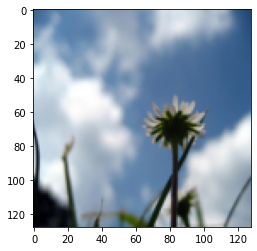

tulip


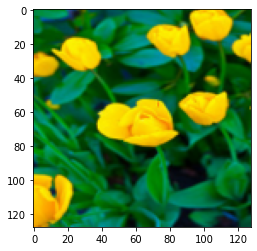

rose


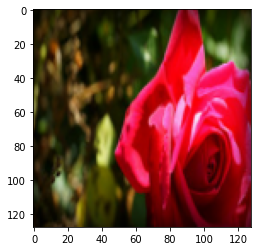

dandelion


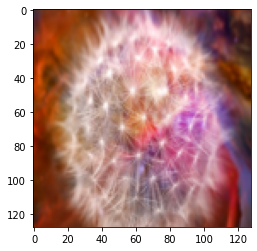

daisy


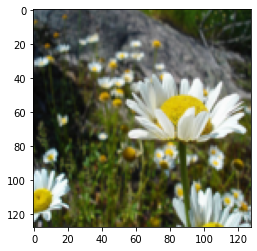

In [113]:
images, labels = iter(train_loader).next()
for image, label in zip(images[:5], labels[:5]):
    print(full_dataset.classes[label])
    show_image(image)

### Training

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [115]:
def plot_loss_and_accuracy(loss, accuracy):
    plt.figure(figsize=(16, 5))
    plt.suptitle('Average values loss and accuracy at each epoch')

    epochs = [i+1 for i in range(len(loss))]
    plt.subplot(121)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, loss)

    plt.subplot(122)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, accuracy)

In [116]:
def test_model(model):
    global test_loader
    global device

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network: {accuracy}')
    return accuracy

In [117]:
def train_model(model, epoch = 1, lr=0.005):
    global train_loader
    global device

    accuracy_values = []
    loss_values = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    total = len(train_loader) * epoch
    progress_bar = iter(tqdm(range(total), total=total, desc="Processing records"))
    for epoch in range(epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_loader:
            next(progress_bar)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        loss = running_loss / len(train_loader)
        loss_values.append(loss)
        print(f'[{epoch + 1}] loss: {loss}')

        accuracy = test_model(model)
        accuracy_values.append(accuracy)
    torch.cuda.empty_cache()

    try:
        next(progress_bar)
    except StopIteration:
        pass

    print('Finished Training')
    plot_loss_and_accuracy(loss_values, accuracy_values)

In [176]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(SIZE[0] * SIZE[1] * CHANNELS_NUMBER, 120),
            nn.ReLU()
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.linear3 = nn.Linear(84, CLASS_NUMBER)
        

    def forward(self, data):
        data = data.view(-1, SIZE[0] * SIZE[1] * CHANNELS_NUMBER)
        
        data = self.linear1(data)
        data = self.linear2(data)
        result = self.linear3(data)
        
        return result

Processing records:   0%|          | 0/3645 [00:00<?, ?it/s]

[1] loss: 1.365918126125885
Accuracy of the network: 42.361111111111114
[2] loss: 1.2073356980158958
Accuracy of the network: 41.898148148148145
[3] loss: 1.1081973701838113
Accuracy of the network: 38.888888888888886
[4] loss: 1.0156098400614388
Accuracy of the network: 40.50925925925926
[5] loss: 0.9462442600432738
Accuracy of the network: 45.601851851851855
[6] loss: 0.8806296476611385
Accuracy of the network: 43.05555555555556
[7] loss: 0.790465700282972
Accuracy of the network: 44.21296296296296
[8] loss: 0.7694326412285306
Accuracy of the network: 42.824074074074076
[9] loss: 0.7275123086608486
Accuracy of the network: 41.666666666666664
[10] loss: 0.6965950264484303
Accuracy of the network: 45.138888888888886
[11] loss: 0.6582249578993016
Accuracy of the network: 43.05555555555556
[12] loss: 0.5817996140860726
Accuracy of the network: 44.21296296296296
[13] loss: 0.5326422887237229
Accuracy of the network: 45.370370370370374
[14] loss: 0.5367261446061938
Accuracy of the network:

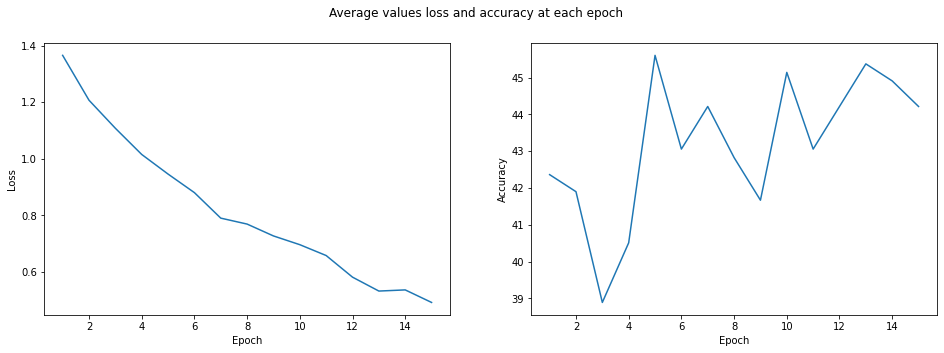

In [178]:
linear_net = LinearNet().to(device)
train_model(linear_net, 15)

Модель с простыми линейными слоями справилась с задачей лучше, чем просто рандом. В данном случае она достигла 45% точности после 8 эпох, дальше точность стала скакать.

In [52]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(CHANNELS_NUMBER, 6, 7), 
            nn.ReLU()
        )
        size = (SIZE[0] - 6, SIZE[1] - 6)
        
        self.pool = nn.MaxPool2d(2, 2) 
        size = (size[0] // 2, size[1] // 2)
        
        self.linear_input_size = size[0] * size[1] * 6

        self.linear1 = nn.Sequential(
            nn.Linear(self.linear_input_size, 120),
            nn.ReLU()
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.linear3 = nn.Linear(84, CLASS_NUMBER)

    def forward(self, data):
        data = self.conv1(data)
        data = self.pool(data)
        
        data = data.view(-1, self.linear_input_size)

        data = self.linear1(data)
        data = self.linear2(data)
        result = self.linear3(data)
        
        return result

Processing records:   0%|          | 0/2430 [00:00<?, ?it/s]

[1] loss: 1.338826389715014
Accuracy of the network: 44.21296296296296
[2] loss: 1.1657860517011258
Accuracy of the network: 47.68518518518518
[3] loss: 1.076984757994428
Accuracy of the network: 49.30555555555556
[4] loss: 0.9618500430642822
Accuracy of the network: 53.00925925925926
[5] loss: 0.8330174517729645
Accuracy of the network: 53.7037037037037
[6] loss: 0.7018674921106409
Accuracy of the network: 50.69444444444444
[7] loss: 0.5806302375508925
Accuracy of the network: 50.23148148148148
[8] loss: 0.46069028719094557
Accuracy of the network: 48.842592592592595
[9] loss: 0.4007294109482088
Accuracy of the network: 51.851851851851855
[10] loss: 0.3551593942744006
Accuracy of the network: 50.925925925925924
Finished Training


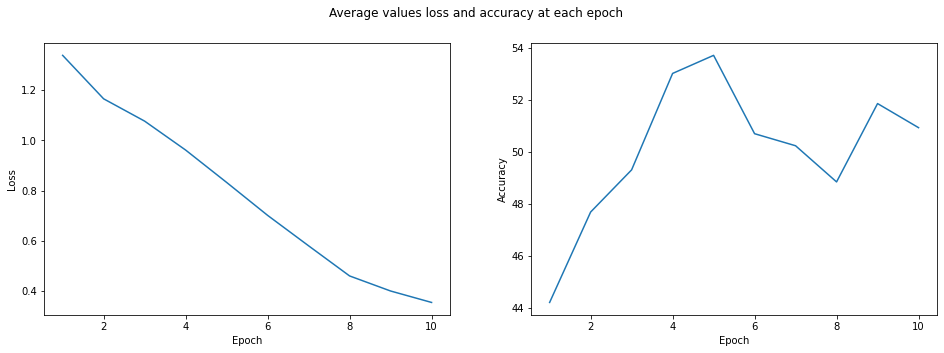

In [53]:
conv_net = ConvNet().to(device)
train_model(conv_net, 10)

Модель со свёрточным слоем показала результаты немного лучше предыдущей модели. Точность дошла до 53%, а потом резко упала.
Возможно, нужно усложнить модель, чтобы избежать переобучения.

In [171]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(CHANNELS_NUMBER, 6, 7), 
            nn.ReLU()
        )
        size = (SIZE[0] - 6, SIZE[1] - 6)
        
        self.pool1 = nn.AvgPool2d(2, 2) 
        size = (size[0] // 2, size[1] // 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 12, 5), 
            nn.ReLU()
        )
        size = (size[0] - 4, size[1] - 4)
        
        self.pool2 = nn.MaxPool2d(2, 2) 
        size = (size[0] // 2, size[1] // 2)
        
        self.linear_input_size = size[0] * size[1] * 12

        self.linear1 = nn.Sequential(
            nn.Linear(self.linear_input_size, 120),
            nn.ReLU()
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        
        self.linear3 = nn.Linear(84, CLASS_NUMBER)

    def forward(self, data):
        data = self.conv1(data)
        data = self.pool1(data)
        
        data = self.conv2(data)        
        data = self.pool2(data)
        
        data = data.view(-1, self.linear_input_size)

        data = self.linear1(data)
        data = self.linear2(data)
        result = self.linear3(data)
        
        return result

Processing records:   0%|          | 0/2430 [00:00<?, ?it/s]

[1] loss: 1.4974220166971655
Accuracy of the network: 39.583333333333336
[2] loss: 1.2178670835102536
Accuracy of the network: 45.601851851851855
[3] loss: 1.104116456498825
Accuracy of the network: 49.53703703703704
[4] loss: 1.0123636433126504
Accuracy of the network: 55.324074074074076
[5] loss: 0.8816444135497137
Accuracy of the network: 56.01851851851852
[6] loss: 0.739760315957874
Accuracy of the network: 51.620370370370374
[7] loss: 0.6139057599345352
Accuracy of the network: 46.06481481481482
[8] loss: 0.5338259524523966
Accuracy of the network: 45.138888888888886
[9] loss: 0.43517086990637543
Accuracy of the network: 52.31481481481482
[10] loss: 0.35039185485783425
Accuracy of the network: 49.53703703703704
Finished Training


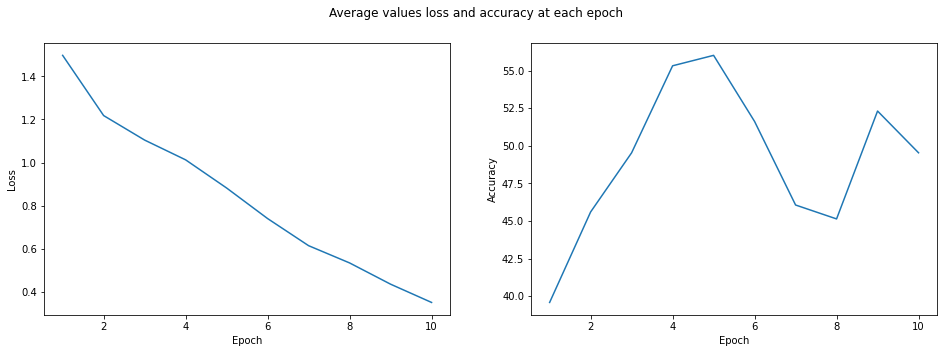

In [172]:
conv_net2 = ConvNet2().to(device)
train_model(conv_net2, 10)

Модель с дополнительным свёрточным слоем показала точность лучше предыдущих, но очень быстро переобучилась.

In [174]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        size = (SIZE[0] - 2, SIZE[1] - 2)
        size = (size[0] // 2, size[1] // 2)
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        size = (size[0] - 2, size[1] - 2)
        size = (size[0] // 2, size[1] // 2)
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        size = (size[0] - 2, size[1] - 2)
        size = (size[0] // 2, size[1] // 2)
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        size = (size[0] - 2, size[1] - 2)
        size = (size[0] // 2, size[1] // 2)
        self.linear_input_size = size[0] * size[1] * 32
        
        self.fc1 = nn.Linear(self.linear_input_size, 5)
        
    def forward(self, data):
        data = self.layer1(data)
        data = self.layer2(data)
        data = self.layer3(data)
        data = self.layer4(data)
        data = data.view(-1, self.linear_input_size)
        data = self.fc1(data)

        return data

Processing records:   0%|          | 0/2430 [00:00<?, ?it/s]

[1] loss: 1.341523308812836
Accuracy of the network: 54.861111111111114
[2] loss: 1.020688580510057
Accuracy of the network: 58.7962962962963
[3] loss: 0.8812438302324632
Accuracy of the network: 60.416666666666664
[4] loss: 0.7993474266656633
Accuracy of the network: 61.342592592592595
[5] loss: 0.7264768940553744
Accuracy of the network: 62.96296296296296
[6] loss: 0.6636359883556641
Accuracy of the network: 60.879629629629626
[7] loss: 0.6034256008304195
Accuracy of the network: 59.72222222222222
[8] loss: 0.5376542878984915
Accuracy of the network: 60.18518518518518
[9] loss: 0.4839176152346065
Accuracy of the network: 60.18518518518518
[10] loss: 0.4390810479107217
Accuracy of the network: 59.72222222222222
Finished Training


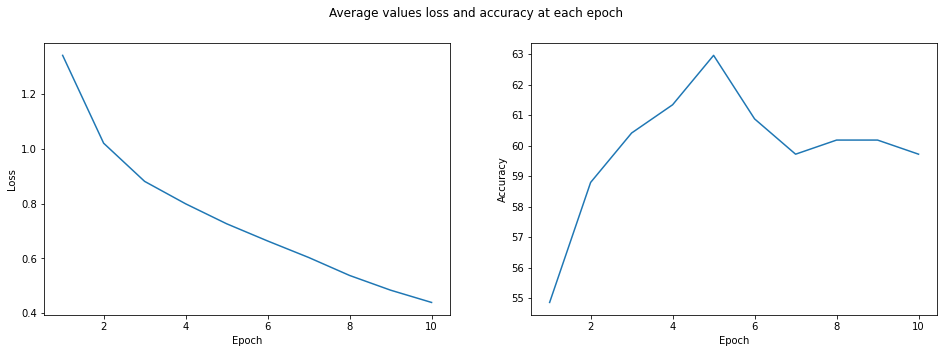

In [175]:
conv_net3 = ConvNet3().to(device)
train_model(conv_net3, 10)

Вот такая модель с добавленной batch нормализацией и дополнительными свёрточными слоями показала наилучший результат. В данном случае 61%. 